# import libraries

In [1]:
!python -m nltk.downloader stopwords

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Electronica\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import string
import pandas as pd
import numpy as np
import re
import joblib
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

# Loading the Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df=pd.read_csv("News Detections_Training Part.csv")

# Cleaning the Dataset

In [5]:
df.drop(columns=['news_reply','news_url','source_domain'],inplace=True)


In [6]:
df

real                                               news
0         1  Kandi Burruss Explodes Over Rape Accusation on...
1         1  People's Choice Awards 2018: The best red carp...
2         1  Sophia Bush Sends Sweet Birthday Message to 'O...
3         1  Colombian singer Maluma sparks rumours of inap...
4         1  Gossip Girl 10 Years Later: How Upper East Sid...
...     ...                                                ...
16994     1    How Amber Rose Became an Unlikely Feminist Icon
16995     0  Rihanna Cradles Newborn Baby in Loving Twitter...
16996     1  Kourtney Kardashian and Younes Bendjima Are Ma...
16997     1  Emmy Awards 2017: Elisabeth Moss found out abo...
16998     0  Jason Aldean Gig Canceled After He Sells Out T...

[16999 rows x 2 columns]

# Handling Duplicated Values

In [7]:
df.duplicated().sum()

817

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.duplicated().sum()

0

In [10]:
df

real                                               news
0         1  Kandi Burruss Explodes Over Rape Accusation on...
1         1  People's Choice Awards 2018: The best red carp...
2         1  Sophia Bush Sends Sweet Birthday Message to 'O...
3         1  Colombian singer Maluma sparks rumours of inap...
4         1  Gossip Girl 10 Years Later: How Upper East Sid...
...     ...                                                ...
16994     1    How Amber Rose Became an Unlikely Feminist Icon
16995     0  Rihanna Cradles Newborn Baby in Loving Twitter...
16996     1  Kourtney Kardashian and Younes Bendjima Are Ma...
16997     1  Emmy Awards 2017: Elisabeth Moss found out abo...
16998     0  Jason Aldean Gig Canceled After He Sells Out T...

[16182 rows x 2 columns]

In [11]:
df.isnull()

real   news
0      False  False
1      False  False
2      False  False
3      False  False
4      False  False
...      ...    ...
16994  False  False
16995  False  False
16996  False  False
16997  False  False
16998  False  False

[16182 rows x 2 columns]

In [12]:
df.isnull().sum()

real    0
news    0
dtype: int64

In [13]:
df.describe()

real
count  16182.000000
mean       0.758126
std        0.428231
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000

## Text Cleaning

In [14]:
STOP_WORDS = set(stopwords.words("english"))

LEMMATIZER = WordNetLemmatizer()


def clean_mentions(text: str):
    return re.sub(r"@[a-zA-Z0-9_]+", "", text)


def clean_URLs(text: str):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)


def clean_HTML5_entities(text: str):
    return re.sub(r"&[a-z]+;", "", text)


def clean_punctuations(text: str):
    return re.sub(r"\W", " ", text)


def clean_numbers(text: str):
    return re.sub(r"[0-9]+", "", text)


def clean_stopwords(text: str):
    return " ".join([token for token in text.split() if token not in STOP_WORDS])


def lemmatize_text(text: str):
    return " ".join([LEMMATIZER.lemmatize(token, pos="v") for token in text.split()])


def normalize(text: str):
    text = text.lower()
    text = clean_mentions(text)
    text = clean_URLs(text)
    text = clean_HTML5_entities(text)
    text = clean_punctuations(text)
    text = clean_numbers(text)
    text = clean_stopwords(text)
    text = lemmatize_text(text)
    return text

In [15]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Electronica\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
df["news"] = df["news"].apply(str.lower)
df['news'] = df['news'].apply(clean_URLs)
df['news'] = df['news'].apply(clean_HTML5_entities)
df['news'] = df['news'].apply(clean_numbers)
df['news'] = df['news'].apply(clean_stopwords)
df['news'] = df['news'].apply(clean_punctuations)
df["news"] = df["news"].apply(lemmatize_text)
display(df['news'])

0        kandi burruss explode rape accusation real hou...
1               people s choice award best red carpet look
2        sophia bush send sweet birthday message one tr...
3        colombian singer maluma spark rumour inappropr...
4        gossip girl years later upper east siders shoc...
                               ...                        
16994             amber rise become unlikely feminist icon
16995     rihanna cradle newborn baby love twitter picture
16996    kourtney kardashian younes bendjima make paris...
16997        emmy award elisabeth moss find nomination gif
16998            jason aldean gig cancel sell liberals snl
Name: news, Length: 16182, dtype: object

# Vectorize The Text

In [17]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Max words
tfidf_features = tfidf_vectorizer.fit_transform(df['news'])

## Spliting the data

In [18]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_features, df['real'], test_size=0.2, random_state=42) # x,y

## Model Training

In [19]:
model = SVC(kernel='linear', probability=True)
model.fit(x_train, y_train)

SVC(kernel='linear', probability=True)

## Model Accuracy

In [20]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)


Model Accuracy: 0.8322520852641334


# Confusion Matrix and Accuracy

In [21]:
# Step 1: Confusion Matrix and Accuracy
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)

Confusion Matrix:
[[ 386  402]
 [ 141 2308]]
Accuracy: 0.8322520852641334


In [22]:
# Step 2: Precision, Recall, and F1-score
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.49      0.59       788
           1       0.85      0.94      0.89      2449

    accuracy                           0.83      3237
   macro avg       0.79      0.72      0.74      3237
weighted avg       0.82      0.83      0.82      3237



# AUC-ROC Curve

In [23]:
# Step 3: AUC-ROC Curve
y_probs = model.predict_proba(x_test)[:,1]
auc_roc = roc_auc_score(y_test, y_probs)
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix:
[[ 386  402]
 [ 141 2308]]


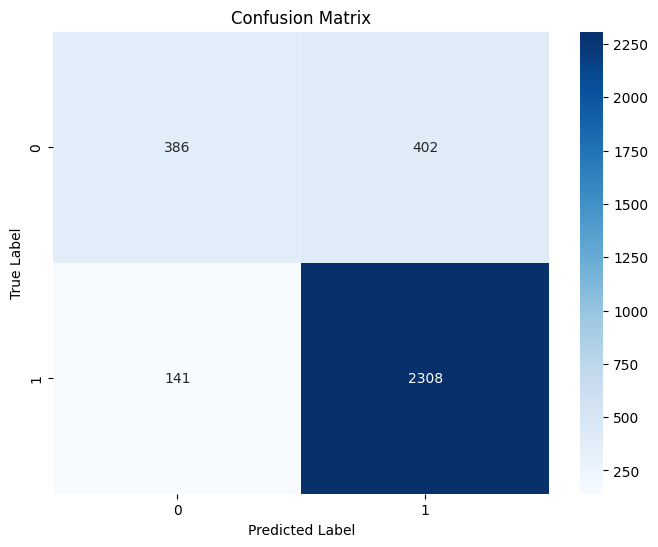

In [24]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Display Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [25]:
# Cross-Validation
cv_scores = cross_val_score(model, tfidf_features, df['real'], cv=5)  # 5-fold cross-validation
print("Cross-Validation Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Mean Accuracy: 0.8330245580591835


In [26]:
# Grid Search
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly']
}
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=3)
grid_search.fit(x_train, y_train)
print("Best Parameters (Grid Search):", grid_search.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.793 total time=  31.7s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.792 total time=  26.5s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.791 total time=  28.6s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.791 total time=  29.4s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.795 total time=  32.6s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.771 total time=  36.5s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.769 total time=  37.8s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.774 total time=  38.1s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.772 total time=  36.9s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.771 total time=  37.3s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.759 total time=  57.4s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;

In [ ]:
# Random Search
param_dist = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly']
}
random_search = RandomizedSearchCV(model, param_dist, cv=5, n_iter=10, random_state=42, verbose=3)
random_search.fit(x_train, y_train)
print("Best Parameters (Random Search):", random_search.best_params_)

## Process User Input and Predict

In [28]:
def preprocess_input(text):
    cleaned_text = normalize(text)
    transformed_text = tfidf_vectorizer.transform([cleaned_text]).toarray()
    return transformed_text

def predict_real_or_fake(text):
    transformed_text = preprocess_input(text)
    prediction = model.predict(transformed_text)
    real_or_fake_mapping = {0: 'fack',1:'real'}
    real_or_fake = real_or_fake_mapping[prediction[0]]
    return real_or_fake

## Test with User Input

In [29]:
text="Kandi Burruss Explodes Over Rape Accusation on 'Real Housewives of Atlanta' Reunion (Video)"
real_or_fake = predict_real_or_fake(text)
print(f"Text: '{text}'")
print(f"Predicted Real or Fake: {real_or_fake}\n")

Text: 'Kandi Burruss Explodes Over Rape Accusation on 'Real Housewives of Atlanta' Reunion (Video)'
Predicted Real or Fake: real



# save the model

In [31]:
joblib.dump(model, "real_or_fake_model.SVM")

['real_or_fake_model.SVM']